In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

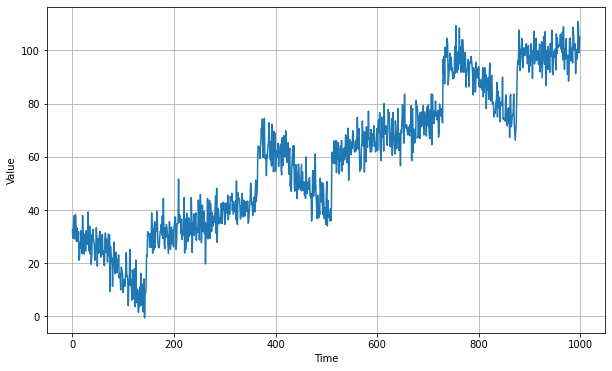

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)


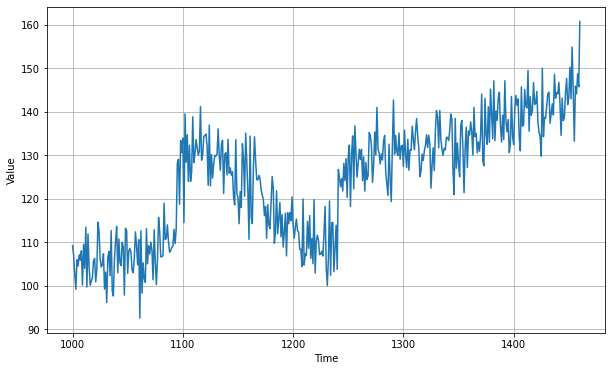

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


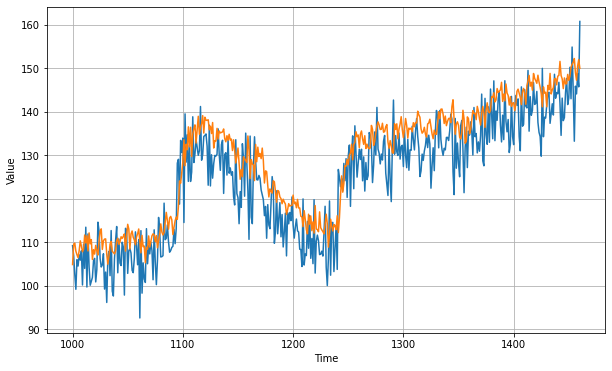

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.0559707

In [31]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 402.9964
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 159.2422
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 101.6423
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 95.1128
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 94.7574
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 94.4560
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 94.2157
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 93.8390
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 93.3894
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 92.8921
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 92.3501
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 91.7464
Epoch 13/100
31/31 [==

(1e-08, 0.001, 0.0, 300.0)

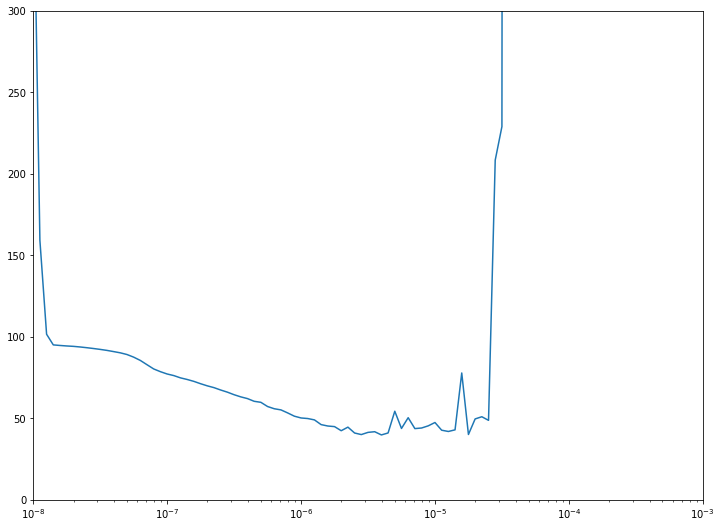

In [32]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(12, 9))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [49]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=4.4e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

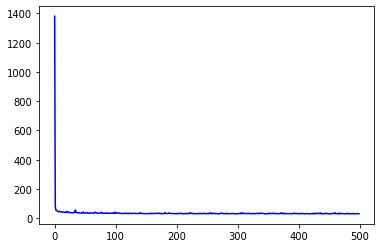

In [50]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[43.00733184814453, 42.107059478759766, 41.08655548095703, 41.525062561035156, 42.44826126098633, 41.07661437988281, 40.36883544921875, 41.41920471191406, 39.383445739746094, 39.18082809448242, 46.12831497192383, 44.88316345214844, 41.20170211791992, 38.01082992553711, 40.35386657714844, 37.994361877441406, 37.55694580078125, 38.634117126464844, 36.96335220336914, 37.05116271972656, 37.199031829833984, 38.67014694213867, 39.489105224609375, 40.471046447753906, 56.005775451660156, 37.711612701416016, 39.112728118896484, 38.525840759277344, 37.262630462646484, 34.8682746887207, 36.86355209350586, 35.8459358215332, 35.344566345214844, 34.68924331665039, 36.02645492553711, 34.610984802246094, 35.937110900878906, 43.06163024902344, 35.34596633911133, 34.874847412109375, 34.7464714050293, 36.450626373291016, 36.48324966430664, 34.548404693603516, 37.63858413696289, 35.227210998535156, 34.9369010925293, 33.785926818847656, 35.14670181274414, 34.54812240600586, 36.9397087097168, 36.03658294677

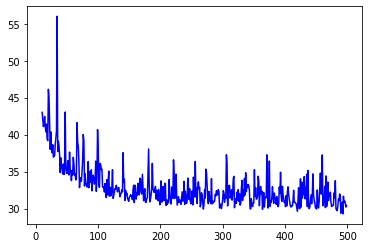

In [51]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

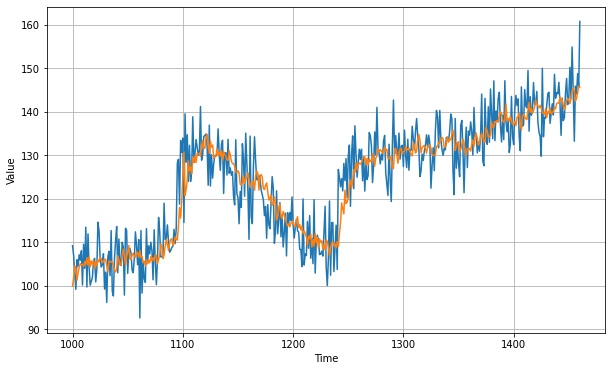

In [52]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.505231